In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.misc import imread
import matplotlib.image as mpimg

def getCameraCalibrationMatrix(img):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret != True:
        print('Loading calibration image error')
        raise

    objpoints.append(objp)
    imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

def getPerspectiveMatrixes(w, h):
    srcPoints = np.float32(
        [[w * 0.18, h * 0.95],
         [w * 0.457, h * 0.63],
         [w * 0.543, h * 0.63],
         [w * 0.82, h * 0.95]])
    dstPoints = np.float32(
        [[w * 0.25, h],
         [w * 0.25, 0],
         [w * 0.75, 0],
         [w * 0.75, h]])
    
    M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
    Minv = cv2.getPerspectiveTransform(dstPoints, srcPoints)

    return M, Minv

def warpImage(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  # keep same size as input image
    return warped

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def binaryImage(img, thresh=(110, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    sumImg = np.maximum.reduce([adjust_gamma(L, 0.3),S])
    
    binary = np.zeros_like(sumImg)
    binary[(sumImg >= thresh[0]) & (sumImg <= thresh[1])] = 1

    return binary


def find_window_centroids(image, window_width = 50, window_height = 80, margin = 100):
    leftx = []
    rightx = []
    ploty = np.linspace(0, 719, int(720 / window_height))
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    leftx.append(l_center)
    rightx.append(r_center)

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        leftx.append(l_center)
        rightx.append(r_center)
    
    leftx = leftx[::-1]
    rightx = rightx[::-1]

    return (leftx, ploty, rightx, ploty)

def find_window_centroids2(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return (left_fitx, ploty, right_fitx, ploty, left_fit, right_fit)

def drawCentroids(img, leftx, lefty, rightx, righty, window_height = 80):

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

    left_points = np.vstack(([left_fitx.T], [lefty.T])).T
    right_points = np.vstack(([right_fitx.T], [righty.T])).T
    all_points = np.concatenate((left_points, right_points[::-1]))

    cv2.fillConvexPoly(img, np.int32([all_points]), (0, 255, 0))

    cv2.polylines(img, np.int32([left_points]), False, (255, 0, 0), 20)
    cv2.polylines(img, np.int32([right_points]), False, (255, 0, 0), 20)
        
    return img

def getCurvature(ploty, leftx, lefty, rightx, righty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return (left_curverad, right_curverad)

def getCenter(leftx, rightx):
    left = leftx[len(leftx) - 1]
    right = rightx[len(rightx) - 1]
    center = (left + right) / 2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (1280/2 - center)*xm_per_pix


# init
mtx, dist = getCameraCalibrationMatrix(cv2.imread('camera_cal/calibration2.jpg'))
M, Minv = getPerspectiveMatrixes(1280, 720)

print("Camera calibration matrix:", mtx)

Camera calibration matrix: [[ 872.5223319     0.          649.38554509]
 [   0.          853.10470045  213.74930061]
 [   0.            0.            1.        ]]


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = 1
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = 1
        
    x_start_stop[0] = int(x_start_stop[0] * img.shape[1])
    x_start_stop[1] = int(x_start_stop[1] * img.shape[1])
    y_start_stop[0] = int(y_start_stop[0] * img.shape[0])
    y_start_stop[1] = int(y_start_stop[1] * img.shape[0])
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [3]:
# Read in cars and notcars
cars = glob.glob('train_data/vehicles/**/*.png')
notcars = glob.glob('train_data/non-vehicles/**/*.png')

print('Cars: ', len(cars), ", non-cars: ", len(notcars))

Cars:  8792 , non-cars:  8968


In [4]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7068
20.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9885


In [ ]:
img = cv2.cvtColor(cv2.imread("test_images/yes1.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img)

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(20,10))
ax1.set_title('H')
ax1.imshow(hsv[:,:,0], cmap='gray')

ax2.set_title('S')
ax2.imshow(hsv[:,:,1], cmap='gray')

ax3.set_title('V')
ax3.imshow(hsv[:,:,2], cmap='gray')

ax4.set_title('H')
ax4.imshow(hls[:,:,0], cmap='gray')

ax5.set_title('L')
ax5.imshow(hls[:,:,1], cmap='gray')

ax6.set_title('S')
ax6.imshow(hls[:,:,2], cmap='gray')

ax7.set_title('L')
ax7.imshow(luv[:,:,0], cmap='gray')

ax8.set_title('U')
ax8.imshow(luv[:,:,1], cmap='gray')

ax9.set_title('V')
ax9.imshow(luv[:,:,2], cmap='gray')

ax10.set_title('R')
ax10.imshow(img[:,:,0], cmap='gray')

ax11.set_title('G')
ax11.imshow(img[:,:,1], cmap='gray')

ax12.set_title('B')
ax12.imshow(img[:,:,2], cmap='gray')

ax13.set_title('Y')
ax13.imshow(ycrcb[:,:,0], cmap='gray')

ax14.set_title('Cr')
ax14.imshow(ycrcb[:,:,1], cmap='gray')

ax15.set_title('Cb')
ax15.imshow(ycrcb[:,:,2], cmap='gray')

plt.show()

In [ ]:
img = cv2.cvtColor(cv2.imread("test_images/yes1.jpg"), cv2.COLOR_BGR2RGB)

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
in_img = hsv[:,:,2]

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(in_img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(in_img, cmap='gray')
ax1.set_title('Input')

ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Visualization')

plt.show()

In [ ]:
img = cv2.cvtColor(cv2.imread("test_images/yes1.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img)

rhist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
ghist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
bhist = np.histogram(img[:,:,2], bins=32, range=(0, 256))

bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')

In [ ]:
image = cv2.cvtColor(cv2.imread("test_images/test5.jpg"), cv2.COLOR_BGR2RGB)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0.5, 0.85], xy_window=(128, 128), xy_overlap=(0.66, 0.66))

image = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
image = draw_boxes(image, [windows[0]], color=(255, 255, 255), thick=6)
plt.imshow(image)
plt.show()

In [ ]:
image = cv2.cvtColor(cv2.imread("test_images/test5.jpg"), cv2.COLOR_BGR2RGB)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0.50, 0.75], xy_window=(96, 96), xy_overlap=(0.66, 0.66))

image = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
image = draw_boxes(image, [windows[0]], color=(255, 255, 255), thick=6)
plt.imshow(image)
plt.show()

In [ ]:
image = cv2.cvtColor(cv2.imread("test_images/test5.jpg"), cv2.COLOR_BGR2RGB)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0.50, 0.70], xy_window=(72, 72), xy_overlap=(0.66, 0.66))

image = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
image = draw_boxes(image, [windows[0]], color=(255, 255, 255), thick=6)
plt.imshow(image)
plt.show()

In [ ]:
image = cv2.cvtColor(cv2.imread("test_images/test5.jpg"), cv2.COLOR_BGR2RGB)

windows = slide_window(image, x_start_stop=[0.1, 0.9], y_start_stop=[0.50, 0.70], xy_window=(72, 72), xy_overlap=(0.66, 0.66))

image = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
image = draw_boxes(image, [windows[0]], color=(255, 255, 255), thick=6)
plt.imshow(image)
plt.show()

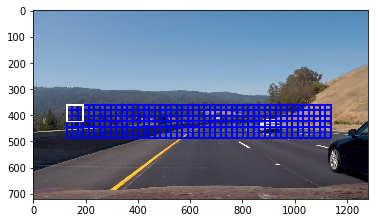

In [10]:
image = cv2.cvtColor(cv2.imread("test_images/test9.jpg"), cv2.COLOR_BGR2RGB)

windows = slide_window(image, x_start_stop=[0.1, 0.9], y_start_stop=[0.50, 0.70], xy_window=(64, 64), xy_overlap=(0.66, 0.66))

image = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
image = draw_boxes(image, [windows[0]], color=(255, 255, 255), thick=6)
plt.imshow(image)
plt.show()

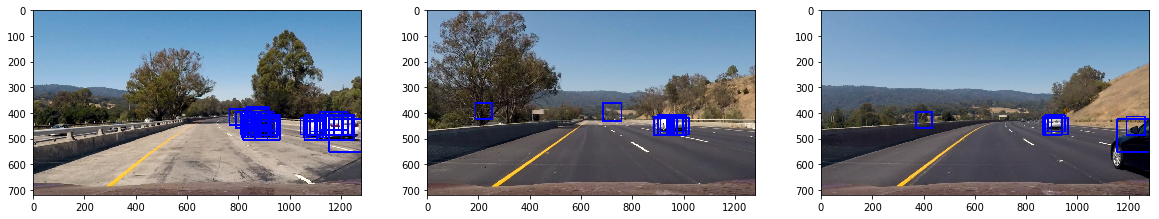

In [11]:
def detect_vehicles(image):
    #windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[0.5, 1], xy_window=(256, 256), xy_overlap=(0.5, 0.5))
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[0.5, 0.85], xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[0.5, 0.75], xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=[0.5, 0.7], xy_window=(72, 72), xy_overlap=(0.75, 0.75))
    windows5 = slide_window(image, x_start_stop=[0.1,0.9], y_start_stop=[0.5, 0.7], xy_window=(64, 64), xy_overlap=(0.8, 0.8))
    all_hot_windows = []
    
    hot_windows = search_windows(image, windows2, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    all_hot_windows.extend (hot_windows)

    hot_windows = search_windows(image, windows3, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    all_hot_windows.extend (hot_windows)

    hot_windows = search_windows(image, windows4, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    all_hot_windows.extend (hot_windows)

    hot_windows = search_windows(image, windows5, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    all_hot_windows.extend (hot_windows)

    return all_hot_windows


%matplotlib inline 

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20,10))
image = cv2.cvtColor(cv2.imread("test_images/test1.jpg"), cv2.COLOR_BGR2RGB)
boxes = detect_vehicles(image)
ax1.imshow(draw_boxes(image, boxes, color=(0, 0, 255), thick=6))

image = cv2.cvtColor(cv2.imread("test_images/test8.jpg"), cv2.COLOR_BGR2RGB)
boxes = detect_vehicles(image)
ax2.imshow(draw_boxes(image, boxes, color=(0, 0, 255), thick=6))

image = cv2.cvtColor(cv2.imread("test_images/test9.jpg"), cv2.COLOR_BGR2RGB)
boxes = detect_vehicles(image)
ax3.imshow(draw_boxes(image, boxes, color=(0, 0, 255), thick=6))

plt.show()

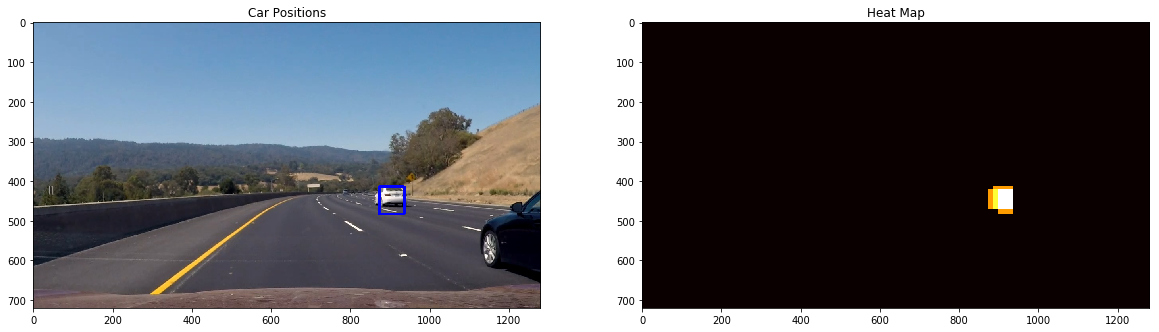

In [12]:
def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def process_all_heatmap(heatmaps, heatmap, frames = 10):
    heatmaps.append(heatmap)
    while (len(heatmaps) > frames):
        heatmaps.pop(0)
    return np.mean(heatmaps, axis=0)

image = cv2.cvtColor(cv2.imread("test_images/test9.jpg"), cv2.COLOR_BGR2RGB)
heat = np.zeros_like(image[:,:,0]).astype(np.float)

box_list = detect_vehicles(image)
add_heat(heat, box_list)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
apply_threshold(heatmap, 2)

heatmaps = []
final_heatmap = process_all_heatmap(heatmaps, heatmap)

# Find final boxes from heatmap using label function
labels = label(final_heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(draw_img)
ax1.set_title('Car Positions')

ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map')

plt.show()

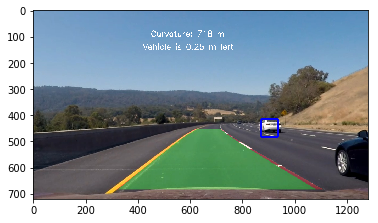

In [14]:
heatmaps = []

def processImage(img):
    global final_heatmap
    global heatmaps
    ##############################
    # lines detection
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = warpImage(undist, M)
    binary = binaryImage(warped)
    leftx, lefty, rightx, righty, left_fit, right_fit = find_window_centroids2(binary)
    highlight_warped = drawCentroids(np.zeros_like(warped), leftx, lefty, rightx, righty)
    highlight = warpImage(highlight_warped, Minv)
    output = cv2.addWeighted(undist, 1, highlight, 0.3, 0.0)
    
    left_curverad, right_curverad = getCurvature(lefty, leftx, lefty, rightx, righty, left_fit, right_fit)
    curvature = min([left_curverad, right_curverad])
    
    text = "Curvature: {} m".format(int(curvature))
    cv2.putText(output, text, (450,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    pos = getCenter(leftx, rightx)
    if pos < 0:
        text = "Vehicle is {:.2f} m left".format(-pos)
    else:
        text = "Vehicle is {:.2f} m right".format(pos)
    cv2.putText(output, text, (420,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    ##############################
    # cars detection
    box_list = detect_vehicles(img)
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)

    add_heat(heatmap, box_list)
    apply_threshold(heatmap, 2)
    heatmap[heatmap > 0] = 1

    #heatmap = np.clip(heatmap, 0, 255)
    
    final_heatmap = process_all_heatmap(heatmaps, heatmap)
    apply_threshold(final_heatmap, 0.8)
    
    # Find final boxes from heatmap using label function
    labels = label(final_heatmap)
    output = draw_labeled_bboxes(output, labels)
    
    return output


heatmaps = []
img = processImage(cv2.cvtColor(cv2.imread("test_images/test9.jpg"), cv2.COLOR_BGR2RGB))
plt.imshow(img)
plt.show()

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'out.mp4'
curr_frame = 0
all_heatmap = None
final_heatmap = None

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
clip1 = VideoFileClip("project_video.mp4")#.subclip(27, 28)
white_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [5:47:22<00:16, 16.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

Wall time: 5h 47min 23s
